In [134]:
import os
import csv
#import time
import pandas as pd
import numpy as np
#import pyterrier as pt
import matplotlib.pyplot as plt

In [135]:
import collections
from collections import defaultdict, OrderedDict
import queue as Q

In [136]:
# Definimos algunas funciones

In [137]:
def compute_at_backend(q):
    return query_costs[q]

In [153]:
class LRUCache:
    def __init__(self, size):
        self.size = size
        self.lru_cache = collections.OrderedDict()
    def get(self, key):
        try:
            value = self.lru_cache.pop(key)
            self.lru_cache[key] = value
            return value
        except KeyError:
            return -1
    def put(self, key, value):
        try:
            self.lru_cache.pop(key)
        except KeyError:
            if len(self.lru_cache) >= self.size:
                self.lru_cache.popitem(last=False)
            self.lru_cache[key] = value
    def dump_cache(self):
        print (self.lru_cache)

In [154]:
class LFUCache:
    def __init__(self, capacity):
        self.remain = capacity
        self.least_freq = 1
        self.node_for_freq = collections.defaultdict(collections.OrderedDict)
        self.node_for_key = dict()
    def _update(self, key, value):
        _, freq = self.node_for_key[key]
        self.node_for_freq[freq].pop(key)
        if len(self.node_for_freq[self.least_freq]) == 0:
            self.least_freq += 1
        self.node_for_freq[freq+1][key] = (value, freq+1)
        self.node_for_key[key] = (value, freq+1)
    def get(self, key):
        if key not in self.node_for_key:
            return -1
        value = self.node_for_key[key][0]
        self._update(key, value)
        return value
    def put(self, key, value):
        if key in self.node_for_key:
            self._update(key, value)
        else:
            self.node_for_key[key] = (value,1)
            self.node_for_freq[1][key] = (value,1)
            if self.remain == 0:
                removed = self.node_for_freq[self.least_freq].popitem(last=False)
                self.node_for_key.pop(removed[0])
            else:
                self.remain -= 1
                self.least_freq = 1
                #
    def dump(self):
        print (self.node_for_freq)

In [203]:
class FxCCache:
    def __init__(self, capacity):
        self.remain = capacity
        self.item_fxcq  = Q.PriorityQueue()     # (fxc, key)
        self.item_valid = dict()                # Para una key, guarda el fxc válido
        self.item_freq  = dict()                # Frecuencia de key
        self.item_cost  = dict()                # Costo de key
    #
    def dump_freq(self):
        print (self.item_freq)
    #
    def dump_queue(self):
        tmp = Q.PriorityQueue() # (fxc, key)
        while not self.item_fxcq.empty():
            it = self.item_fxcq.get()
            print (it, end = ' '),
            tmp.put(it)
        print ()
        self.item_fxcq = tmp
    #
    def _update(self, key):
        self.item_freq[key] += 1
        fxc = (self.item_freq[key]) * self.item_cost[key]
        self.item_valid[key] = fxc
        self.item_fxcq.put((fxc, key))
        #print (fxc)
        return fxc
    
    def get(self, key):
        if key not in self.item_freq:
            return -1
        up = self._update(key)       # Tengo que freq+=1 y actualizar fx en la cola
        return up

    #
    def put(self, key, cost):
        if key in self.item_freq:
            self._update(key) # Tengo que freq+=1 y actualizar fxc en la cola
        else:
            self.item_freq[key] = 1
            self.item_cost[key] = cost
            fxc = cost
            #
            if self.remain == 0:
                while True:
                    remove = self.item_fxcq.get()
                    rkey = remove[1]
                    valid_fxc = self.item_valid[rkey]
                    if remove[0] == valid_fxc:
                        del(self.item_freq[rkey])
                        del(self.item_cost[rkey])
                        break
            else:
                self.remain -= 1
            # El item lo inserto despues de remover el menor
            self.item_fxcq.put((fxc, key))
            self.item_valid[key] = fxc

In [8]:
# Se carga en un diccionario el costo de los queries del log para simular el tiempo de cómputo en el back end.
query_costs = {}
with open("../data/AOL_360k_sample.unique.times", "r") as fin:
    for line in fin:
        q, t = line.strip().split(",")
        query_costs[q] = float(t)

In [9]:
#
#


In [10]:
queries_to_process = []
times_to_process = []
#
with open("../data/AOL_360k_sample.txt", "r") as fin:
    for query in fin:
        query = query.strip()
        cost = compute_at_backend(query)
        #
        queries_to_process.append(query)
        times_to_process.append(cost)
    #
total_queries = len(queries_to_process)

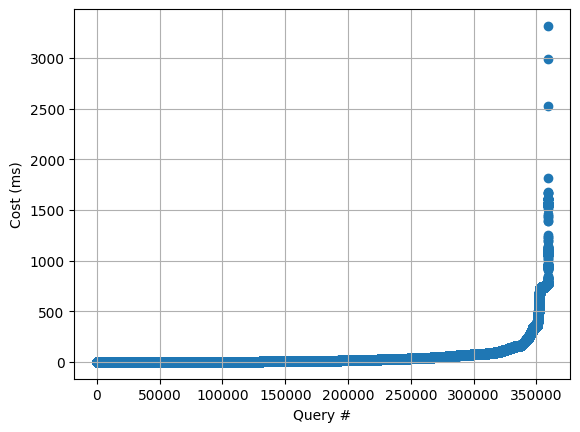

In [11]:
# Graficamos los costos de los queries
y_axis = sorted(times_to_process)
x_axis = range(0, len(y_axis))
#
plt.scatter(x_axis, y_axis)
plt.grid()
plt.xlabel("Query #")
plt.ylabel("Cost (ms)")

plt.show()

In [12]:
#
total_time = sum(times_to_process)
mean_time  = np.mean(times_to_process)
p90_time   = np.percentile(times_to_process, 90)
p99_time   = np.percentile(times_to_process, 99)
max_time   = max(times_to_process)
#
print (f'Cantidad de queries: {total_queries}')
print (f'Tiempo total       : {total_time:.2f} ms')
print (f'Tiempo medio       : {mean_time:.2f} ms')
print (f'Tiempo P90 (tail)  : {p90_time:.2f} ms')
print (f'Tiempo P99 (tail)  : {p99_time:.2f} ms')
print (f'Tiempo Máximo P100): {max_time:.2f} ms')

Cantidad de queries: 359168
Tiempo total       : 18025987.30 ms
Tiempo medio       : 50.19 ms
Tiempo P90 (tail)  : 110.78 ms
Tiempo P99 (tail)  : 741.30 ms
Tiempo Máximo P100): 3317.14 ms


**Tarea 1: Probar LRU con el ejemplo de las diapos**

In [43]:
mycache = LRUCache(3)

In [44]:
mycache.put(1, "A")
mycache.put(2, "B")
mycache.put(3, "C")
mycache.dump_cache()

OrderedDict([(1, 'A'), (2, 'B'), (3, 'C')])


In [45]:
mycache.get(2)
mycache.dump_cache()

OrderedDict([(1, 'A'), (3, 'C'), (2, 'B')])


In [46]:
mycache.get(4)

-1

In [47]:
mycache.put(4, "D")
mycache.dump_cache()

OrderedDict([(3, 'C'), (2, 'B'), (4, 'D')])


In [48]:
mycache.get(3)
mycache.dump_cache()

OrderedDict([(2, 'B'), (4, 'D'), (3, 'C')])


In [49]:
mycache.put(1, "A")
mycache.dump_cache()

OrderedDict([(4, 'D'), (3, 'C'), (1, 'A')])


In [50]:
mycache.get(3)
mycache.dump_cache()

OrderedDict([(4, 'D'), (1, 'A'), (3, 'C')])


In [155]:
lfu = LFUCache(3)
lfu.put(1, "A")
lfu.put(2, "B")
lfu.put(2, "B")
lfu.put(3, "C")
lfu.put(4, "D")
lfu.put(5, "E")
lfu.put(5, "E")
lfu.put(6, "F")
lfu.put(6, "F")
lfu.dump()#

defaultdict(<class 'collections.OrderedDict'>, {1: OrderedDict(), 2: OrderedDict([(2, ('B', 2)), (5, ('E', 2)), (6, ('F', 2))])})


In [159]:
lfu.get(6)

'F'

In [212]:
fxc = FxCCache(3)

In [213]:
fxc.put(1,  10)
fxc.dump_freq()
fxc.put(2,  20)
fxc.dump_freq()
fxc.put(1,  10)
fxc.dump_freq()
fxc.put(1,  10)
fxc.dump_freq()
fxc.put(4,  40)
fxc.dump_freq()
fxc.put(5,  50)

{1: 1}
{1: 1, 2: 1}
{1: 2, 2: 1}
{1: 3, 2: 1}
{1: 3, 2: 1, 4: 1}


{1: 3, 4: 1, 5: 1}


In [216]:
fxc.get(1)

60

**Tarea 1: Probar desde 1 hasta n tal que Elias_Gamma_Coding(n) requiera más bits que Binary(n)**

### Pruebas simples con VByte

**Tarea 3: Calcular en qué valor ocurre el siguiente salto en bytes (de 2 a 3)**

### Ejemplo con Bit Packing